In [1]:
# pytorch로 신경망 모델 훈련하기

# 데이터 준비
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='.', train=True, download= True)
fm_test = FashionMNIST(root='.', train= False, download= True)

train_input = fm_train.data
train_target = fm_train.targets
train_scaled = train_input / 255.0

from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [ ]:
# 밀집층 사이에 드롭아웃 추가
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100,10)
)
# GPU에 적재
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [3]:
# 손실 함수와 옵티마이저 준비
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# 필요한 변수 준비
train_hist = [] # 훈련손실 기록
val_hist = []   # 검증손실 기록
patience = 2
best_loss = -1 # 최상손실 기록
early_stopping_counter = 0

In [5]:
epochs = 20
batches = int(len(train_scaled)/32)
for epoch in range(epochs):
    model.train() 
    train_loss = 0 # 에포크 손실 초기화
    for i in range(batches):
        inputs = train_scaled[i*32:(i+1)*32].to(device) # 배치입력과 타깃 준비
        targets = train_target[i*32:(i+1)*32].to(device)
        optimizer.zero_grad() # 옵티마이저 그레디언트 초기화
        outputs = model(inputs) # 모델에 입력 전달
        loss = criterion(outputs, targets) # 모델 출력과 타깃으로 손실 계산 (정방향 계산, 순전파) -> 배치에있는 샘플에 대한 손실 평균 
        loss.backward() # 손실 역전파
        optimizer.step() # 모델 파라미터 업데이트
        train_loss += loss.item() # 에포크 손실 기록
    model.eval()
    val_loss = 0
    with torch.no_grad():
        val_scaled = val_scaled.to(device)
        val_target = val_target.to(device)
        outputs = model(val_scaled)
        loss = criterion(outputs, val_target)
        val_loss = loss.item()
    train_hist.append(train_loss/batches)
    val_hist.append(val_loss)
    print(f"에포크:{epoch + 1},",f"훈련 손실:{train_loss/batches:.4f}, 검증 손실:{val_loss:.4f}") # 에포크 손실 출력

    # 조기 종료
    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stopping_counter += 1
    if early_stopping_counter >= patience:
        print(f"{epoch+1}번쨰 에포크에서 조기 종료되었습니다.")
        break


에포크:1, 훈련 손실:0.6081, 검증 손실:0.4442
에포크:2, 훈련 손실:0.4435, 검증 손실:0.3924
에포크:3, 훈련 손실:0.4063, 검증 손실:0.3739
에포크:4, 훈련 손실:0.3837, 검증 손실:0.3578
에포크:5, 훈련 손실:0.3705, 검증 손실:0.3489
에포크:6, 훈련 손실:0.3578, 검증 손실:0.3481
에포크:7, 훈련 손실:0.3481, 검증 손실:0.3314
에포크:8, 훈련 손실:0.3381, 검증 손실:0.3411
에포크:9, 훈련 손실:0.3286, 검증 손실:0.3371
9번쨰 에포크에서 조기 종료되었습니다.


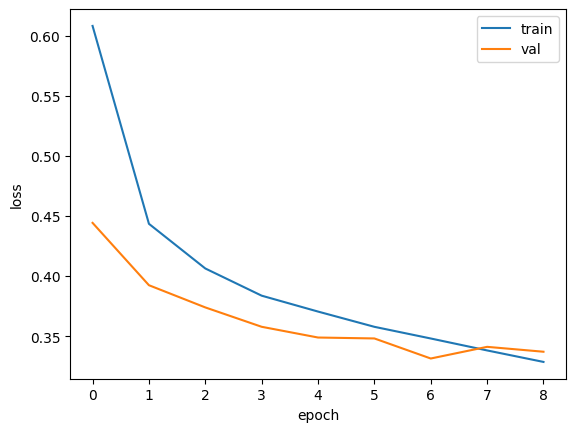

In [6]:
# 훈련손실, 검증손실 그래프
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [7]:
# torch.load()로 torch.save()로 저장한 모델이나 텐서를 불러올 수 있음
# load_state_dict()로 state_dict()로 저장한 데이터를 다시 모델에 복원할때 사용.

# torch.load()함수로 best_model.pt 파일에 저장한 모델 파라미터를 읽은 다음 load_state_dict() 메서드에 전달하여 최상의 파라미터로 model객체에 업데이트
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

# 검증세트 성능확인
model.eval()
with torch.no_grad():
    val_scaled = val_scaled.to(device)
    outputs = model(val_scaled)
    predicts = torch.argmax(outputs, 1)
    corrects = (predicts == val_target).sum().item()

accuracy = corrects / len(val_target)
print(f"검증 정확도: {accuracy:.4f}")


검증 정확도: 0.8772
